<a href="https://colab.research.google.com/github/juliuswiscmsba/NLP-Disaster-Tweets/blob/main/NLP_Disaster_Tweets_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NLP Disaster Tweets from Kaggle

Apply LSTM and BERT to deal with text, and Random Forest to work on other columns (combining the result from BERT and LSTM).

Version 2.0: Repalce keyword by the result of applying Naive Bayes in text. 

REFERENCE:
1. https://www.kaggle.com/code/tmishinev/nlp-d-tweets-keras-bert-0-83/notebook
2. https://www.kaggle.com/code/datafan07/disaster-tweets-nlp-eda-bert-with-transformers#Building-the-Bert-Model
3. https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
4. https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b
5. https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d
6. https://www.kaggle.com/code/ryanluoli2/a-complete-guide-to-naive-bayes-classifiers/notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, Activation, RepeatVector, Bidirectional, LSTM, Dropout, Embedding
from tensorflow.python.keras.layers.embeddings import Embedding 
from keras.losses import sparse_categorical_crossentropy
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier


In [2]:
nltk.download(['stopwords',
               'wordnet',
               'omw-1.4'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
from google.colab import files
train = files.upload()
test = files.upload()

Saving train.csv to train.csv


Saving test.csv to test.csv


In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
#Deal with NA
train.keyword.fillna('Unknown', inplace=True)
train.location.fillna('Unknown', inplace=True)
test.keyword.fillna('Unknown', inplace=True)
test.location.fillna('Unknown', inplace=True)

In [7]:
#Observe 'Keywords' column
train.keyword.value_counts().head(20)
#Some unknown value 
#Lemmatize seems to be a good method to deal with it. (weapon and weapons)

Unknown        61
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
evacuate       40
fear           40
outbreak       40
siren          40
twister        40
windstorm      40
collided       40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
Name: keyword, dtype: int64

In [8]:
#Observe 'location' column
train.location.value_counts().head(20)
#Too many unknown value, we should drop this column when running a ML or DL model, otherwise it may create noise that impact our predict.

Unknown            2535
USA                 104
New York             71
United States        50
London               45
Canada               29
Nigeria              28
UK                   27
Los Angeles, CA      26
India                24
Mumbai               22
Washington, DC       21
Kenya                20
Worldwide            19
Chicago, IL          18
Australia            18
California           17
Everywhere           15
California, USA      15
New York, NY         15
Name: location, dtype: int64

Text(0.5, 1.0, 'Distribution of words in each text')

<Figure size 576x360 with 0 Axes>

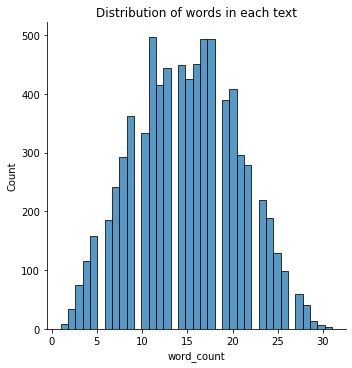

In [9]:
#Observe 'text' column 
train['word_count'] = train['text'].apply(lambda x : len(x.split()))
plt.figure(figsize = (8,5))
sns.displot(data=train, x='word_count')
plt.title("Distribution of words in each text")
#Most tweets contain less than 30 words, and the distribution looks good.

Text(0.5, 1.0, 'Distribution of the Target Label')

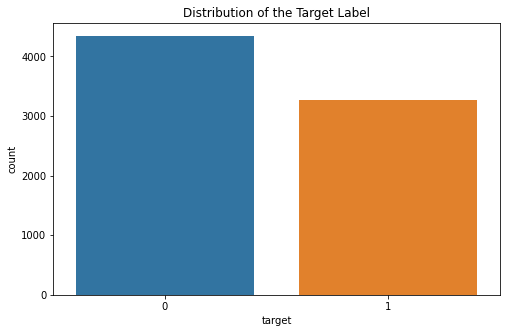

In [10]:
#Oberseve 'target' column
plt.figure(figsize = (8,5))
sns.countplot(data = train, x = 'target')
plt.title('Distribution of the Target Label')
#0 is slightly more than 1 -> if unbalance, we should deal with it.

In [11]:
#Text cleaning and lemmatize
def clean_text(text):
    text = text.lower()
    space = re.compile('[/(){}\[\]\|@,;#]')
    text = re.sub(space,' ', text) 
    ignore = re.compile('[^0-9a-z #+_]')
    text = re.sub(ignore,'', text)
    return text

def remove_stopwords(text):
    StopWords = nltk.corpus.stopwords.words('english')
    text = ' '.join(word for word in text.split() if word not in StopWords) # remove stopwors from text
    return text

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'
        u'\U0001F300-\U0001F5FF'  
        u'\U0001F680-\U0001F6FF'  
        u'\U0001F1E0-\U0001F1FF'  
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def lemmatizer(text):
    text = text.split(" ")
    word_lem = WordNetLemmatizer()
    l_text = ""
    for t in text:
        l = word_lem.lemmatize(t)
        l_text += l
        l_text += " "
    
    return l_text

train['text'] = train['text'].apply(remove_html)
train['text'] = train['text'].apply(remove_url)
train['text'] = train['text'].apply(remove_emoji)
train['text'] = train['text'].apply(clean_text)
train['text'] = train['text'].apply(remove_stopwords)
train['text'] = train['text'].apply(lemmatizer)
train['keyword'] = train['keyword'].apply(lemmatizer)

test['text'] = test['text'].apply(remove_html)
test['text'] = test['text'].apply(remove_url)
test['text'] = test['text'].apply(remove_emoji)
test['text'] = test['text'].apply(clean_text)
test['text'] = test['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(lemmatizer)
test['keyword'] = test['keyword'].apply(lemmatizer)

First we build a BiLSTM model using only the text data

In [12]:
X = train.text
y = train.target

In [13]:
#define the LSTM model
def LSTM_model():
    model = tf.keras.Sequential([
        Input(name='inputs',shape=[50]),
        Embedding(len(tok.word_index), 128),
        Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=0.2)),
        Bidirectional(tf.keras.layers.LSTM(64)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])
    
    return model

In [14]:
#Split the train, validation, and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, test_size = 0.1, random_state = 42)

In [15]:
#Tokenizer
tok = Tokenizer()
tok.fit_on_texts(X_train)

#text to sequences
train_sequences = tok.texts_to_sequences(X_train)
val_sequences = tok.texts_to_sequences(X_val)
test_sequences = tok.texts_to_sequences(X_test)

#pad sequences
X_train_seq = pad_sequences(train_sequences,maxlen=50)
X_val_seq = pad_sequences(val_sequences,maxlen=50)
X_test_seq = pad_sequences(test_sequences,maxlen=50)


lstm_model = LSTM_model()
#train the model
history = lstm_model.fit(X_train_seq, y_train, epochs=15,
                    validation_data =(X_val_seq, y_val), batch_size = 32, 
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False, restore_best_weights=True)])

Epoch 1/15
172/172 [==============================] - 19s 40ms/step - loss: 0.6770 - accuracy: 0.5692 - val_loss: 0.6608 - val_accuracy: 0.6059
Epoch 2/15
172/172 [==============================] - 4s 25ms/step - loss: 0.5349 - accuracy: 0.7389 - val_loss: 0.4770 - val_accuracy: 0.7734
Epoch 3/15
172/172 [==============================] - 5s 27ms/step - loss: 0.3251 - accuracy: 0.8706 - val_loss: 0.4840 - val_accuracy: 0.7882
Epoch 4/15
172/172 [==============================] - 6s 33ms/step - loss: 0.2342 - accuracy: 0.9142 - val_loss: 0.5403 - val_accuracy: 0.7652
Epoch 5/15
172/172 [==============================] - 6s 35ms/step - loss: 0.1750 - accuracy: 0.9391 - val_loss: 0.6322 - val_accuracy: 0.7800
Epoch 6/15
172/172 [==============================] - 6s 34ms/step - loss: 0.1372 - accuracy: 0.9498 - val_loss: 0.6370 - val_accuracy: 0.7685


In [16]:
yhat = np.where(lstm_model.predict(X_test_seq) >=0.5,1,0)

In [17]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       869
           1       0.84      0.68      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



Accuracy Score:  0.8063033486539725


Text(51.0, 0.5, 'Real')

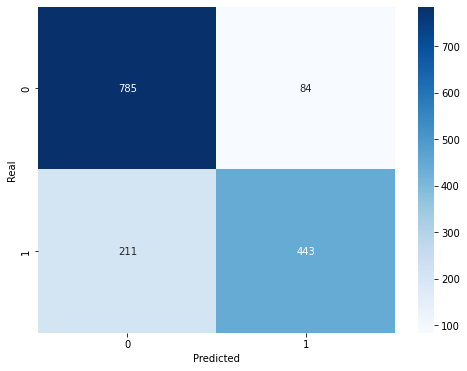

In [18]:
print('Accuracy Score: ', accuracy_score(y_test, yhat))
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test, yhat), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Real')

In [19]:
#StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

X_train_all = train['text']
X_test = test['text']

y_train_list = []
y_test_list = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"Fold: {fold+1},", end=' ')
    X_train, X_val = X[train_idx], X[test_idx]
    y_train, y_val = y[train_idx], y[test_idx]
    
    
    #Tokenizer
    tok = Tokenizer()
    tok.fit_on_texts(X_train)

    #Text to sequences
    train_sequences = tok.texts_to_sequences(X_train)
    val_sequences = tok.texts_to_sequences(X_val)
    test_sequences = tok.texts_to_sequences(X_test)
    train_sequences_all = tok.texts_to_sequences(X_train_all)

    #Padded sequences
    X_train_seq = pad_sequences(train_sequences, maxlen=50)
    X_val_seq = pad_sequences(val_sequences, maxlen=50)
    X_test_seq = pad_sequences(test_sequences, maxlen=50)
    X_train_seq_all = pad_sequences(train_sequences_all, maxlen=50)

    #Modeling
    lstm_model = LSTM_model()
    
    history = lstm_model.fit(X_train_seq, y_train, epochs=15,
                    validation_data =(X_val_seq, y_val), batch_size = 32, 
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', 
                    patience=3, verbose=False, restore_best_weights=True)])


    yhat_val =  np.where(lstm_model.predict(X_val_seq) >=0.5,1,0)
    
    f_score = f1_score(y_val, yhat_val)
    a_score = accuracy_score(y_val, yhat_val)
    print('F1 Score: ', f_score)
    print('Accuracy Score: ', a_score)
    print(classification_report(y_val, yhat_val))
    
    y_train_list.append(lstm_model.predict(X_train_seq_all))
    y_test_list.append(lstm_model.predict(X_test_seq))

print('Done...')

Fold: 1, Epoch 1/15
191/191 [==============================] - 11s 29ms/step - loss: 0.6757 - accuracy: 0.5749 - val_loss: 0.6393 - val_accuracy: 0.6205
Epoch 2/15
191/191 [==============================] - 4s 20ms/step - loss: 0.4738 - accuracy: 0.7905 - val_loss: 0.4506 - val_accuracy: 0.7997
Epoch 3/15
191/191 [==============================] - 4s 20ms/step - loss: 0.3042 - accuracy: 0.8773 - val_loss: 0.4741 - val_accuracy: 0.8017
Epoch 4/15
191/191 [==============================] - 4s 20ms/step - loss: 0.2113 - accuracy: 0.9217 - val_loss: 0.5309 - val_accuracy: 0.7997
Epoch 5/15
191/191 [==============================] - 4s 20ms/step - loss: 0.1563 - accuracy: 0.9424 - val_loss: 0.5956 - val_accuracy: 0.7905
Epoch 6/15
191/191 [==============================] - 5s 24ms/step - loss: 0.1214 - accuracy: 0.9603 - val_loss: 0.6051 - val_accuracy: 0.7899
F1 Score:  0.7625786163522013
Accuracy Score:  0.8017071569271176
              precision    recall  f1-score   support

           

In [20]:
#Store prediction to the submission file
test['target'] = np.where(np.mean(y_test_list, axis = 0) >=0.5, 1,0)
sub_lstm = test[['id','target']].copy()
sub_lstm.to_csv('submission_lstm.csv', index = False)
files.download('submission_lstm.csv')
#Result: 0.79865

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
#Prepare for the random forest model -> we need to probability of the prediction (both train and test)
train['lstm_pred'] = np.mean(y_train_list, axis = 0) 
test['lstm_pred'] = np.mean(y_test_list, axis = 0)

In [22]:
train.head()

,id,keyword,location,text,target,word_count,lstm_pred
0,1,Unknown,Unknown,deed reason earthquake may allah forgive u,1,13,0.777934
1,4,Unknown,Unknown,forest fire near la ronge sask canada,1,7,0.964422
2,5,Unknown,Unknown,resident asked shelter place notified officer ...,1,22,0.960636
3,6,Unknown,Unknown,13 000 people receive wildfire evacuation orde...,1,8,0.974284
4,7,Unknown,Unknown,got sent photo ruby alaska smoke wildfire pour...,1,16,0.811371


BERT

In [23]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 8.3 MB/s 
     |████████████████████████████████| 120 kB 61.8 MB/s 
     |████████████████████████████████| 6.6 MB 53.0 MB/s 


In [24]:
#Load BERT model
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    hidden_dropout_prob = 0.15,
    attention_probs_dropout_prob = 0.15,
    hidden_act = "relu",
    num_labels = 2
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
#BERT tolenizer
input_ids=[]
attention_masks=[]

sentences=train['text']
labels=train['target']
for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent, add_special_tokens = True, max_length =64, padding='max_length', return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

In [26]:
#Split the train and test data
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids, labels, attention_masks, test_size=0.2)

In [27]:
#BERT model
model_save_path='bert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path, save_weights_only=True, monitor='val_sparse_categorical_accuracy', mode='max', patience=3, save_best_only=True)]

optimizer = tf.keras.optimizers.Adam(
    learning_rate = 1e-5, 
    epsilon = 1e-07,
    clipvalue = 10
)
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=tf.keras.metrics.SparseCategoricalAccuracy())
bert_model.trainable = True
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [28]:
history=bert_model.fit([train_inp,train_mask],train_label,batch_size=32,epochs=7,validation_data=([val_inp,val_mask],val_label), callbacks=callbacks)

Epoch 1/7
191/191 [==============================] - 116s 442ms/step - loss: 0.5402 - sparse_categorical_accuracy: 0.7296 - val_loss: 0.4510 - val_sparse_categorical_accuracy: 0.7899
Epoch 2/7
191/191 [==============================] - 79s 415ms/step - loss: 0.4189 - sparse_categorical_accuracy: 0.8186 - val_loss: 0.4656 - val_sparse_categorical_accuracy: 0.7971
Epoch 3/7
191/191 [==============================] - 78s 406ms/step - loss: 0.3782 - sparse_categorical_accuracy: 0.8389 - val_loss: 0.4590 - val_sparse_categorical_accuracy: 0.7958
Epoch 4/7
191/191 [==============================] - 79s 415ms/step - loss: 0.3415 - sparse_categorical_accuracy: 0.8627 - val_loss: 0.4569 - val_sparse_categorical_accuracy: 0.8056
Epoch 5/7
191/191 [==============================] - 79s 415ms/step - loss: 0.3085 - sparse_categorical_accuracy: 0.8775 - val_loss: 0.4547 - val_sparse_categorical_accuracy: 0.8260
Epoch 6/7
191/191 [==============================] - 78s 407ms/step - loss: 0.2732 - spar

In [29]:
#Validation prediction
preds = bert_model.predict([val_inp,val_mask],batch_size=32)
pred_labels = np.argmax(preds.logits, axis=1)
f_score = f1_score(val_label,pred_labels)
a_score = accuracy_score(val_label,pred_labels)
print('F1 Score: ', f_score)
print('Accuracy Score: ', a_score)
print('Classification Report:')
print(classification_report(val_label,pred_labels))

print('Training and saving built model.....')   

F1 Score:  0.7720164609053497
Accuracy Score:  0.8181221273801708
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       874
           1       0.83      0.72      0.77       649

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523

Training and saving built model.....


In [30]:
#Tokenize test data
input_ids_test=[]
attention_masks_test=[]

sentences=test['text']
for sent in sentences:
    bert_inp_test=bert_tokenizer.encode_plus(sent, add_special_tokens = True,max_length =64, padding='max_length', return_attention_mask = True)
    input_ids_test.append(bert_inp_test['input_ids'])
    attention_masks_test.append(bert_inp_test['attention_mask'])

input_ids_test=np.asarray(input_ids_test)
attention_masks_test=np.array(attention_masks_test)

In [31]:
preds_test = bert_model.predict([input_ids_test,attention_masks_test],batch_size=32)
test['target']  = np.argmax(preds_test.logits, axis=1)
sub_bert = test[['id','target']].copy()
sub_bert.to_csv('submission_bert.csv', index = False)
files.download('submission_bert.csv')
#Result: 0.82899

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
#Prepare for the random forest model -> we need to probability of the prediction (using softmax function)
preds_train = bert_model.predict([input_ids, attention_masks],batch_size=32)
train['bert_pred'] = tf.nn.softmax(preds_train.logits, axis=1)[:,1]
test['bert_pred'] = tf.nn.softmax(preds_test.logits, axis=1)[:,1]

Random Forest

In [33]:
X_rf = train[['keyword', 'lstm_pred', 'bert_pred']]
y_rf = train['target']
test_rf = test[['keyword', 'lstm_pred', 'bert_pred']]

In [34]:
#LabelEncoder for keywords
le = LabelEncoder()
X_rf['keyword'] = le.fit_transform(X_rf['keyword'])
test_rf['keyword'] = le.transform(test_rf['keyword'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [35]:
#Split to train and validation data
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state = 42)

Accuracy Score:  0.9212081418253447


Text(51.0, 0.5, 'Real')

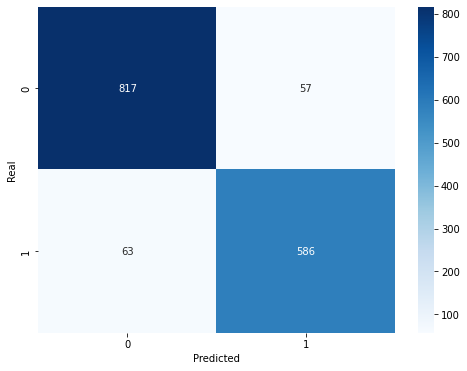

In [36]:
#Random Forest model
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train_rf, y_train_rf)

y_pred_rf = rf.predict(X_val_rf)

print("Accuracy Score: ", accuracy_score(y_val_rf, y_pred_rf))
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_val_rf, y_pred_rf), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Real')

In [37]:
#Store result and submission
target = rf.predict(test_rf)
test['target'] = target
sub_rf = test[['id','target']].copy()
sub_rf.to_csv('submission_rf.csv', index = False)
files.download('submission_rf.csv')
#Result: 0.81244

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

When we combine BERT with Random Forest, it does not improve. 

Conbining keyword with the lstm and bert result seems not a good move.

Try to use Naive Bayes to replace the keyword, since naive bayes is kind of similar (or even upgrade) of using the keyword column.


In [84]:
new_test = test[['id','text','lstm_pred','bert_pred']]
new_test['lstm_target'] = new_test['lstm_pred'].apply(lambda x: 1 if x>=0.5 else 0)
new_test['bert_target'] = new_test['bert_pred'].apply(lambda x: 1 if x>=0.5 else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [85]:
new_test.head()

,id,text,lstm_pred,bert_pred,lstm_target,bert_target
0,0,happened terrible car crash,0.748958,0.979075,1,1
1,2,heard earthquake different city stay safe ever...,0.562884,0.983847,1,1
2,3,forest fire spot pond goose fleeing across str...,0.915640,0.985144,1,1
3,9,apocalypse lighting spokane wildfire,0.796574,0.997879,1,1
4,11,typhoon soudelor kill 28 china taiwan,0.956360,0.997724,1,1


In [43]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer

In [88]:
#Vectorizer for NB
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(train['text'])
y = train['target']
test_X = vectorizer.transform(test['text'])

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [109]:
#train and evaluate models with different alpha values
alpha_values = np.arange(0.01, 10, 0.01)
accuracy_scores = []

for alpha in alpha_values:
    NB = MultinomialNB(alpha=alpha)
    NB.fit(X_train, y_train)
    accuracy_scores.append(metrics.accuracy_score(y_test, NB.predict(X_test)))

performance_NB = pd.DataFrame(columns=['alpha', 'accuracy'])
performance_NB['alpha'] = alpha_values
performance_NB['accuracy'] = accuracy_scores
performance_NB.head()

,alpha,accuracy
0,0.01,0.760070
1,0.02,0.763135
2,0.03,0.765324
3,0.04,0.767075
4,0.05,0.769264


In [110]:
#finds the best alpha value
best_index = performance_NB['accuracy'].idxmax()
performance_NB.iloc[best_index, :]

alpha       3.670000
accuracy    0.801664
Name: 366, dtype: float64

In [99]:
#Apply the best alpha
NB = MultinomialNB(alpha=3.67)
NB.fit(X_train, y_train)

MultinomialNB(alpha=3.67)

In [100]:
new_test['NB_target'] = NB.predict(test_X)

In [104]:
new_test.head()

,id,text,lstm_pred,bert_pred,lstm_target,bert_target,NB_target,vote,target
0,0,happened terrible car crash,0.748958,0.979075,1,1,1,3,1
1,2,heard earthquake different city stay safe ever...,0.562884,0.983847,1,1,1,3,1
2,3,forest fire spot pond goose fleeing across str...,0.915640,0.985144,1,1,1,3,1
3,9,apocalypse lighting spokane wildfire,0.796574,0.997879,1,1,1,3,1
4,11,typhoon soudelor kill 28 china taiwan,0.956360,0.997724,1,1,1,3,1


In [102]:
#Vote for majority
new_test['vote'] = new_test['lstm_target']+new_test['bert_target']+new_test['NB_target']
new_test['target'] = new_test['vote'].apply(lambda x: 1 if x>1 else 0)

In [80]:
sub_final = new_test[['id','target']].copy()
sub_final.to_csv('submission_final.csv', index = False)
files.download('submission_final.csv')
#Result:0.81642

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The moethod of apply Naive Bayes and vote for majority does not improve.

The reason may be the keywords are already contained in the text, which BERT already deal with it.

Also BERT is too good to deal with text. By observeing the testing result, we can find out that when BERT's prediction is different from the other two model's, BERT usually predict correctly.

In conclusion, BERT is awesome!

Future Improvement:

1. Apply the Large BERT Model
2. Better data cleanning process
3. Fine tuning 
4. Other model (Glove, RoBERTa...)